# COMP5046 Assignment2 

Authors:
- Xinyue Wang (440359463)
- Xiang Zhou ()

Both authors made equal contribution to this assignment.

## Read ME


## 1.Load Data

In this section, we load train, validation and test data from Google Drive.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/My Drive/train.csv')
df_test= pd.read_csv('/content/drive/My Drive/test.csv')
df_val= pd.read_csv('/content/drive/My Drive/val.csv')
df_train.head(10)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,Sentence,NER
0,-docstart-,O
1,eu rejects german call to boycott british lamb .,I-ORG O I-MISC O O O I-MISC O O
2,peter blackburn,I-PER I-PER
3,brussels 1996-08-22,I-LOC O
4,the european commission said on thursday it di...,O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...
5,germany 's representative to the european unio...,I-LOC O O O O I-ORG I-ORG O O O I-PER I-PER O ...
6,""" we do n't support any such recommendation be...",O O O O O O O O O O O O O O O O O O O O I-ORG ...
7,he said further scientific study was required ...,O O O O O O O O O O O O O O O O O O O O O O I-...
8,he said a proposal last month by eu farm commi...,O O O O O O O I-ORG O O I-PER I-PER O O O O O ...
9,fischler proposed eu-wide measures after repor...,I-PER O I-MISC O O O O I-LOC O I-LOC O O O O O...


## 2.Data Processing and Insight Analysis

In this section, we do some processing to dataset including:

1. Split sentence and NER by space
2. Build a vocabulary - `word_to_ix` which assigns all words in train, validation and test integer indices for later input embedding construction

Also some insight analysis is conducted including:

1. NER tag distrbution


In [0]:
train_data=[sentence.split() for sentence in df_train.Sentence]
target_y_train=[sentence.split() for sentence in df_train.NER]

test_data=[sentence.split() for sentence in df_test.Sentence]
# target_y_test=[sentence.split() for sentence in df_test.NER]  # all NANs

validation_data=[sentence.split() for sentence in df_val.Sentence]
target_y_validation=[sentence.split() for sentence in df_val.NER]

In [3]:
word_to_ix = {}
for sentence in train_data+validation_data+test_data:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in target_y_train+target_y_validation:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# quick check
print('Word list length: ',len(word_list))
print(tag_to_ix)
for i, (key, val) in enumerate(word_to_ix.items()):
  if i > 10:
    break
  print(key, val)

Word list length:  13972
{'<START>': 0, '<STOP>': 1, 'O': 2, 'I-ORG': 3, 'I-MISC': 4, 'I-PER': 5, 'I-LOC': 6}
-docstart- 0
eu 1
rejects 2
german 3
call 4
to 5
boycott 6
british 7
lamb 8
. 9
peter 10


In [4]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

train_input_index =  to_index(train_data,word_to_ix)
train_output_index = to_index(target_y_train,tag_to_ix)
val_input_index = to_index(validation_data,word_to_ix)
val_output_index = to_index(target_y_validation,tag_to_ix)
test_input_index = to_index(test_data,word_to_ix)

# quick check
print(train_input_index[1])
print(train_output_index[1])

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[3, 2, 4, 2, 2, 2, 4, 2, 2]


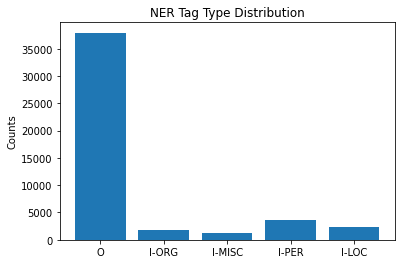

In [5]:
# distribution of labels
import matplotlib.pyplot as pl
from collections import Counter

all_tags = []
for tags in target_y_train+target_y_validation:
  for tag in tags:
    all_tags.append(tag)

counter = Counter(all_tags)
tag_types = list(counter.keys())
tag_counts = list(counter.values())

pl.bar(range(len(tag_types)), tag_counts)
pl.xticks(range(len(tag_types)), tag_types)
pl.ylabel('Counts')
pl.title('NER Tag Type Distribution')
pl.show()

We found there are 5 unique NER tags in the dataset and that the distribution of NER tags are not uniform. Majority of NER tags are "Others". This can create challenges in the model training since the classes are not balanced.


## 3.Input Embeddings

In this section, we implement 3 different types of input embeddings:

1. Word to vec embedding
2. POS tag embedding
3. TF-IDF embedding

The embeddings help project each words into a rich feature space for NER model to learn to best predict the NER tags as accurately as possible. 

We will experiment different combinations of input embeddings and adopt the one gives best result.


### 3.1 Word2Vec Embedding

Here we use the pre-trained word embedding: `glove-twitter-25`.


In [15]:
import gensim.downloader as api
from tqdm.notebook import tqdm

word_emb_model = api.load("glove-twitter-25") 

WORD_EMBEDDING_DIM = 25

word_embedding_matrix = []
for word in tqdm(word_list):
    try:
        word_embedding_matrix.append(word_emb_model.wv[word])
    except:
        word_embedding_matrix.append([0]*WORD_EMBEDDING_DIM)
word_embedding_matrix = np.array(word_embedding_matrix)

# quick check embedding size
print(f'Word embedding matrix shape = {word_embedding_matrix.shape}')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL



Word embedding matrix shape = (13972, 25)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


### 3.2 POS Tag Embedding

Part-of-Speech (POS) is a class of words based on the word's function, they way it works in a sentence.

Having this tag might help the NER model to predict the labels accurately. In this section, we will create POST tag embedding for our vocabulary. 

Note that the final POS tag embedding would be a matrix of size 

```
(vocabulary_size, num_pos_tags)
```

i.e. the POS tag of each word will be one-hot encoded so that each vector is 0-1 vector where 1 refers to the index of the pos tag and all zeros elsewhere.

In [6]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [17]:
word_pos_tag = {}
for word in tqdm(word_list):
  word_pos_tag[word] = nltk.pos_tag(word)[0][-1]


There are 20 kinds of POS tags


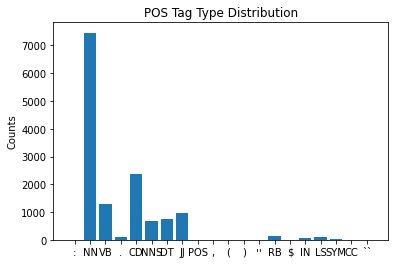

In [22]:
def draw_pos_barchart(word_pos_tag):
  """Visualize the POS tag distribution."""
  all_pos_tags = list(word_pos_tag.values())
  counter = Counter(all_pos_tags)

  tag_types = list(counter.keys())
  tag_counts = list(counter.values())
  print(f'There are {len(tag_types)} kinds of POS tags')
  pl.bar(range(len(tag_types)), tag_counts)
  pl.xticks(range(len(tag_types)), tag_types)
  pl.ylabel('Counts')
  pl.title('POS Tag Type Distribution')
  pl.show()

draw_pos_barchart(word_pos_tag)

#### 3.2.1 Clean POS tags

From the bar chart above we can see there are some invalid pos tags such as following symbols:
```
'$', "''", '(', ')', ',', '.', ':', '``'
```
We need to clean the POS tags a bit to build a good POS tag embedding.


There are 13 kinds of POS tags


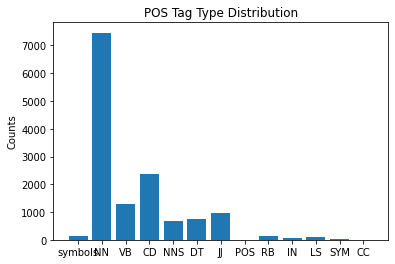

In [23]:
invalid_pos_tags = ['$', "''", '(', ')', ',', '.', ':', '``']
word_pos_tag = {}
for word in tqdm(word_list):
  tag = nltk.pos_tag(word)[0][-1]
  if tag in invalid_pos_tags:
    tag = 'symbols'
  word_pos_tag[word] = tag
draw_pos_barchart(word_pos_tag)

#### 3.2.2 Onehot Encode POS Tag 

In [26]:
pos_tag_to_index = {}
for i, tag in enumerate(set(word_pos_tag.values())):
  pos_tag_to_index[tag] = i
pos_tag_size = len(pos_tag_to_index)
pos_tag_to_index

{'CC': 11,
 'CD': 10,
 'DT': 4,
 'IN': 5,
 'JJ': 2,
 'LS': 3,
 'NN': 8,
 'NNS': 6,
 'POS': 12,
 'RB': 9,
 'SYM': 7,
 'VB': 0,
 'symbols': 1}

In [27]:
pos_embedding_matrix = []
for word in tqdm(word_list):
  pos_vector = [0] * pos_tag_size
  pos_tag = word_pos_tag[word]
  pos_tag_index = pos_tag_to_index[pos_tag]
  pos_vector[pos_tag_index] = 1
  pos_embedding_matrix.append(pos_vector)
pos_embedding_matrix = np.array(pos_embedding_matrix)
print(f'POS Tag Embedding dimension={pos_embedding_matrix.shape}')



POS Tag Embedding dimension=(13972, 13)


### 3.3 TF-IDF Embedding
Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

Note that the final POS tag embedding would be a matrix of size

```
(vocabulary_size, 1)
```

In [34]:
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.pipeline import Pipeline

# get corpus
corpus = df_train['Sentence'].tolist() + df_test['Sentence'].tolist() \
  + df_val['Sentence'].tolist()

# get tfidf score
pipe = Pipeline([('count', CountVectorizer(vocabulary=word_list)),
                 ('tfid', TfidfTransformer())]).fit(corpus)

tfidf_embedding = pipe['tfid'].idf_.reshape(-1, 1)
print(f'TF-IDF Embedding dimension={tfidf_embedding.shape}')

TF-IDF Embedding dimension=(13972, 1)


### 3.4 Modulise Input Embedding

In this section, we modulise the construction of input embedding where the selection of above 3 input embedding is decided when initalise this embedding object.

In [46]:
class Embedding:

  def __init__(self, use_word2vec, use_pos, use_tfidf):
    """Initialise an input embedding given selections of embedding types

    Parameter
    ---------
    use_word2vec: bool
    use_pos: bool
    use_tfidf: bool
    """
    assert any([use_word2vec, use_pos, use_tfidf])
    self.dim = 0
    self.matrix = []

    if use_word2vec:
      self.dim += word_embedding_matrix.shape[-1]
      self.matrix.append(word_embedding_matrix)
    if use_pos:
      self.dim += pos_embedding_matrix.shape[-1]
      self.matrix.append(pos_embedding_matrix)
    if use_tfidf:
      self.dim += tfidf_embedding.shape[-1]
      self.matrix.append(tfidf_embedding)    

    self.matrix = np.concatenate(self.matrix, axis=-1)
    assert self.dim == self.matrix.shape[-1]

# here we use 2 types of input embeddings
embedding = Embedding(use_word2vec=True, use_pos=False, use_tfidf=True)
embedding_dim = embedding.dim
embedding_matrix = embedding.matrix
print(f'Input Embedding Dimension={embedding_matrix.shape}')

Input Embedding Dimension=(13972, 26)


## 4.NER Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score

def cal_acc(model, input_index, output_index):
    predicted=[]
    ground_truth=[]
    for i in range(len(input_index)):

      sentence_in = torch.tensor(input_index[i], dtype=torch.long).to(device)
      pre_sentence = model(sentence_in)

      ground_truth += output_index[i]
      predicted += pre_sentence[1]

    accuracy = accuracy_score(predicted,ground_truth)
        
    return ground_truth, predicted, accuracy

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, embedding_dim, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [0]:
"""Each epoch will take about 1-2 minutes"""

import datetime

for epoch in tqdm(range(20)):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index)
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 10987.73, train acc: 0.9001, val loss: 2651.13, val acc: 0.8719, time: 194.56s
Epoch:2, Training loss: 8095.45, train acc: 0.9015, val loss: 2408.60, val acc: 0.8710, time: 198.11s
Epoch:3, Training loss: 6812.05, train acc: 0.9154, val loss: 2111.42, val acc: 0.8944, time: 195.91s
Epoch:4, Training loss: 5933.18, train acc: 0.9238, val loss: 1920.83, val acc: 0.9026, time: 196.38s
Epoch:5, Training loss: 5221.87, train acc: 0.9306, val loss: 1730.50, val acc: 0.9134, time: 198.51s
Epoch:6, Training loss: 4845.79, train acc: 0.9397, val loss: 1542.26, val acc: 0.9217, time: 197.02s
Epoch:7, Training loss: 4249.25, train acc: 0.9404, val loss: 1586.45, val acc: 0.9236, time: 198.49s


In [0]:
y_true,y_pred,_ = cal_acc(model,val_input_index,val_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))

              precision    recall  f1-score   support

       I-LOC     0.7405    0.9332    0.8258       419
      I-MISC     0.8478    0.6257    0.7200       187
       I-ORG     0.8052    0.4351    0.5649       285
       I-PER     0.9596    0.8697    0.9125       875
           O     0.9643    0.9898    0.9769      5790

    accuracy                         0.9428      7556
   macro avg     0.8635    0.7707    0.8000      7556
weighted avg     0.9425    0.9428    0.9392      7556

